## Technical Overview

An important component of the MKS is the regression technique for rapid calculation of a response field $p\left[i\right]$ based on a microstructure $m\left[i\right]$, where $i$ refers to a discretized spatial location often in 2D or 3D and $\left[\cdot\right]$ indicates a discrete argument over the spatial domain. For example, the microstructure might represent values of material properties that vary based on phase such as elastic modulus or Poisson's ratio while the response might be the stress or strain field.

### Discretize in State Space

The first step in the MKS is to bin (or discretize) the state space. To do this, the microstructure $m$ is discretized and then represented by $m_h$ such that

$$ m\left[i\right] = \sum_{h=0}^{n-1} m_h\left[i\right] \chi_h $$

where $\chi_h$ is the basis representation for the microstructure and $n$ is the number of states. For example if $m \left[i\right] = (0, 2, 1)$, and $n=3$, then $\chi_h = (0, 1, 2)$ and $m_h[i] = ((1, 0, 0), (0, 0, 1), (0, 1, 0))$. Thus,

$$ m_h = \delta_{hm} $$

since the $m$'s are just indices representing the state (the $\left[i\right]$ has been dropped).

### The Influence Coefficients

Once the state space is discretized, the relationship between the response $p$ and microstructure $m_h$ can be written as,

$$ p\left[i\right] = \sum_{h=0}^{n-1} \alpha_h\left[j\right] m_h\left[i - j\right] $$

where the $\alpha_h$ are known as the influence coefficients and describe the relationship between $p$ and $m_h$. The $p$ are a spatial convolution of $\alpha_h$ and $m_h$. In general, it is assumed that both $m_h$ and $p$ are periodic.

*** Note that the formulation above has dropped an index representing the samples for simplicity. Generally the MKS is calibrated using many samples. ***

### The Convolution

The efficiency of the MKS is due to solving the linear regression in Fourier space. For a 2D problem of size $N^2$, the size of the regression is reduced
from $\left(N^2 N_{\text{sample}} \times N^2 H \right)$ to
$\left(N_{\text{sample}} \times H \right)$ for each point in the
Fourier space of size $N^2$. The convolution,

  $$ \sum_{h=0}^{n-1} \alpha_h\left[j\right] m_h \left[i - j\right] $$
  
can be deconvolved in Fourier space using the [circular convolution theorem](http://en.wikipedia.org/wiki/Discrete_Fourier_transform#Circular_convolution_theorem_and_cross-correlation_theorem).

If we write $P \left[k \right] =
 \mathcal{F}_k \{ p\left[i\right] \}$, $M_h \left[k\right]= \mathcal{F}_k
 \{ m_h\left[i\right] \}$ and $\beta\left[k\right] = \mathcal{F}_k \{
 \alpha_h \left[i\right] \}$, then we just need to solve
 
 
   $$ P\left[k\right] = \sum_{h=0}^{n-1} \beta_h \left[k\right] M_h \left[k\right] $$
   
with a linear regression at each discretization location in $k$ to calculate the $\beta_h$.

#### Note about Notation

Throughout PyMKS, the notation follows the signal processing convention of using square brackets [] for discrete variables and round () brackets for continuous variables. As an example, let $x$ be a continuous variable and $x_i$ be a discrete value of $x$ at location $i$. Then the discrete and continuous version of a function $h$ have the following relationship,

$$ h[i] = h(x_i) $$

A discrete convolution also has an implied summation on repeated indices,

$$ h[i] = h(x_i) = \sum_j f(x_j) g(x_i - x_j) = \sum_j f[j] g[i - j] = f[j] g[i - j] $$

## A PyMKS Example

One important application of the MKS is to accurately and rapidly reproduce simulations for any given microstructure. In order to do this we need to instantiate a `MKSRegressionModel` and calibrate the influence coefficients using the `fit` method. Once the influence coefficients have been calibrated, the `predict` method can be used to quickly reproduce the same simulation for any microstructure. The rest of the page will demonstrate how to do this for a finite element simulation for linear elastic strain.

## Linear Elasticity

Let's start by running a finite element simulation on a two phase random microstructure with different elastic moduli. The `ElasticFESimulation` class encapsulates the code needed to run a plain strain problem using SfePy. It solves a plain strain problem on a square domain by straining in the x-direction and applying periodic boundary conditions in the y-direction. The two phase microstructure is represented by `X`.

The `make_elasticFEstrain_random` function from `pymks.datasets` provides a convenient interface to get random microstructures and their strain fields using the `ElasticFESimulation` class. In this case we are going to look at a 15 by 15 two phase microstructure with values of elastic modulus values of 80 and 120. Both phases will have a Poisson's ratio of 0.3.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

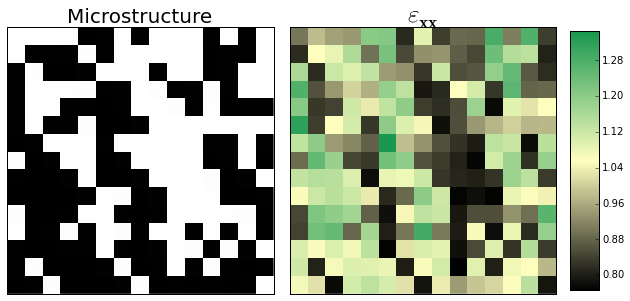

In [2]:
from pymks.tools import draw_microstructure_strain
from pymks.datasets import make_elastic_FE_strain_random

np.random.seed(21)
X, strains = make_elastic_FE_strain_random(n_samples=1, elastic_modulus=(80, 120),
                                           poissons_ratio=(0.3, 0.3), size=(15, 15))

draw_microstructure_strain(X[0], strains[0])

### Create the Delta Microstructures

The goal of the MKS it to quickly reproduce finite element simulations like the one shown above. In the case of linear elasticity, which has distinct phases, the MKS model can be calibrated with two delta microstructures rather than hundreds of random microstructures. The `make_delta_microstructures` function from `pymks.datasets` provides a convenient interface to produce the delta microstructures.

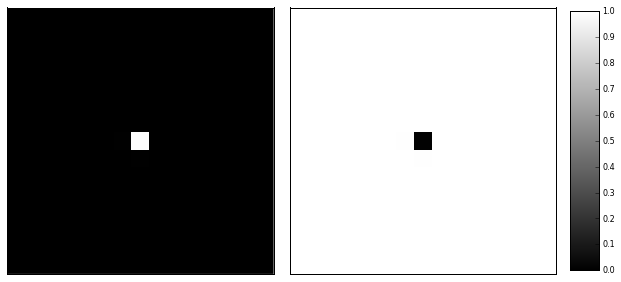

In [3]:
from pymks.tools import draw_microstructures
from pymks.datasets import make_delta_microstructures

X_delta = make_delta_microstructures(n_phases=2, size=(15, 15))
draw_microstructures(X_delta)

### Create the Responses

The `make_elasticFEstrain_delta` function from the `datasets` submodule of `pymks` returns both the delta microstructure and the strain field. The strain fields and microstructures are used as inputs to calibrate the influence coefficients.

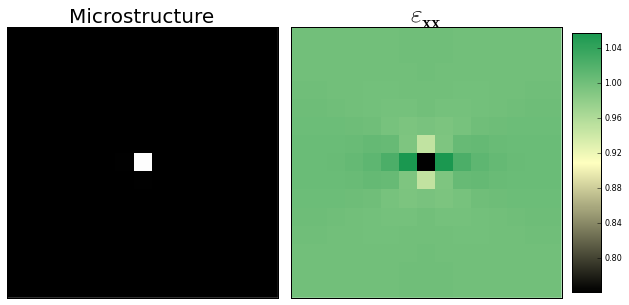

In [4]:
from pymks.datasets import make_elastic_FE_strain_delta

X_delta, strains_delta = make_elastic_FE_strain_delta(elastic_modulus=(80, 120),
                                                      poissons_ratio=(0.3, 0.3),
                                                      size=(15, 15))

draw_microstructure_strain(X_delta[0], strains_delta[0])

### Calibrate the MKS Model

The first step is to calibrate the influence coefficients using the microstructures and strain fields returned by `make_elasticFEstrain_delta`. The `MKSRegressionModel` calibrates the model in the `fit` method. A `DiscreteIndicatorBasis` is needed to discretize the microstructure before passing it to the `fit` method.

In [5]:
from pymks import MKSRegressionModel
from pymks.bases import DiscreteIndicatorBasis

basis = DiscreteIndicatorBasis(n_states=2)

X_delta, y_delta = X_delta, strains_delta
model = MKSRegressionModel(basis=basis)
model.fit(X_delta, y_delta)

### Reproduce the Finite Element Simulation

Now that the influence coefficients have been calibrated using the `fit` method, the original finite element simulation can be reproduced using the `MKSRegressionmModel` by passing the original microstructure into the `predict` method.

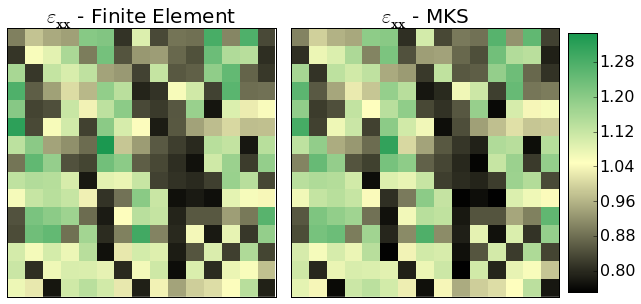

In [6]:
from pymks.tools import draw_strains_compare

X, y = X, strains
y_pred = model.predict(X)
draw_strains_compare(y[0], y_pred[0]);

The `MKSRegressionModel` has done quite a good job of predicting the results from the original FE simulation after calibrating the influence coefficients using delta microstructures.

###Comments

The MKS coefficients can then be scaled up to reproduce larger FE simulations using only the small FE simulation to seed the MKS model.